In [42]:
from pympi import Praat
import json
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from tqdm import tqdm

# Load data
Load forced-aligned TextGrids and KWS probabilities.

In [28]:
textgrid_dir = r'C:\projects\malachor5\data\tira_eval_mfa_aligned'
kws_out_dir = r'C:\projects\malachor5\data\tira_eval_kws'

In [29]:
tg_paths = glob(os.path.join(textgrid_dir, '*.TextGrid'))
tg_paths

['C:\\projects\\malachor5\\data\\tira_eval_mfa_aligned\\HH20210312.TextGrid',
 'C:\\projects\\malachor5\\data\\tira_eval_mfa_aligned\\HH20210913.TextGrid',
 'C:\\projects\\malachor5\\data\\tira_eval_mfa_aligned\\HH20220327-2.TextGrid']

In [30]:
json_paths = glob(os.path.join(kws_out_dir, '*.json'))
json_paths

['C:\\projects\\malachor5\\data\\tira_eval_kws\\HH20210312.json',
 'C:\\projects\\malachor5\\data\\tira_eval_kws\\HH20210913.json',
 'C:\\projects\\malachor5\\data\\tira_eval_kws\\HH20220327-2.json']

# Keyword search / ground truth correlation
How close do the KWS probabilities from CLAP-IPA correlate to the ground truth timestamps of the given word?

Getting the KWS probabilities into vector form is easy: just index the column from the matrix.

In [31]:
with open(json_paths[0], encoding='utf8') as f:
    kws_json = json.load(f)
keywords = kws_json['keywords']
timestamps = kws_json['timestamps']
sim_mat = kws_json['similarity_matrix']
sim_mat = np.array(sim_mat)
sim_mat.shape, len(keywords), len(timestamps)

((5329, 18), 18, 5329)

Ground truth vectors will require some more querying: get all intervals at a given timepoint and check if the interval value corresponds to the keyword or a word within the keyword.

`pympi` doesn't allow direct querying of intervals, so first let's make a dataframe from the textgrid.

In [32]:
def textgrid_to_df(textgrid_path):
    tg = Praat.TextGrid(textgrid_path)
    rows = []
    for tier in tg.get_tiers():
        if 'words' not in tier.name:
            continue
        speaker = tier.name.split()[0]
        for start, end, val in tier.get_all_intervals():
            rows.append({
                'start': start,
                'end': end,
                'text': val,
                'speaker': speaker
            })
    return pd.DataFrame(rows)
df=textgrid_to_df(tg_paths[0])
df.head()

,start,end,text,speaker
0,0.00,0.45,,HIM
1,0.45,0.98,hello,HIM
2,0.98,1.33,hello,HIM
3,1.33,1.66,hello,HIM
4,1.66,1.69,oh,HIM


Then write a function to find all timestamps from a list that are hits for a given keyword.

In [33]:
def is_keyword_hit(df, keyword, midpoint):
    midpoint_mask = (df['start']<=midpoint) & (df['end']>=midpoint)
    keyword_mask = df['text'].isin(keyword.split())
    return 1 if (midpoint_mask & keyword_mask).sum() > 0 else 0

def get_midpoints(timestamps):
    return [(timestamp['end_s']+timestamp['start_s'])/2 for timestamp in timestamps]

def timestamp_hits(df, keyword, timestamps):
    midpoints = get_midpoints(timestamps)
    return np.array([is_keyword_hit(df, keyword, t) for t in midpoints])

hits = timestamp_hits(df, keywords[0], timestamps)

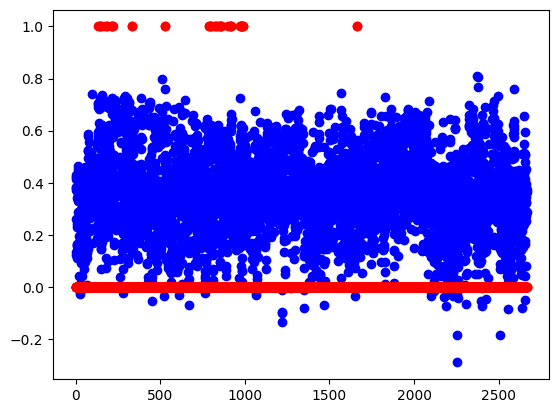

In [34]:
i = 0
kw_probs = sim_mat[:,i]
ground_truth = timestamp_hits(df, keywords[i], timestamps)
midpoints = get_midpoints(timestamps)

plt.scatter(midpoints, kw_probs, c='blue')
plt.scatter(midpoints, ground_truth, c='red')
plt.show()


# EER
Plot the ROC curve and write a function to get the Equal Error Rate for keyword detection

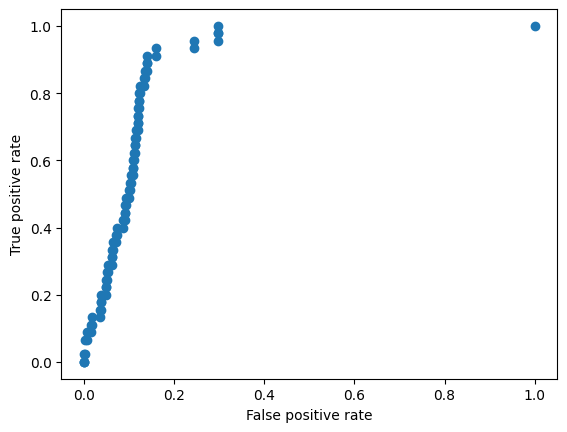

In [35]:
fpr, tpr, thresholds=roc_curve(ground_truth, kw_probs)
plt.scatter(fpr, tpr)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [36]:
# taken from https://yangcha.github.io/EER-ROC/ on 18 Apr 2025
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
eer, thresh

(0.13607115821459553, array(0.52232796))

# Put it all together

In [48]:
for json_path, tg_path in zip(json_paths, tg_paths):
    print(tg_path)
    with open(json_path, encoding='utf8') as f:
        kws_json = json.load(f)
    keywords = kws_json['keywords']
    timestamps = kws_json['timestamps']
    sim_mat = kws_json['similarity_matrix']
    sim_mat = np.array(sim_mat)

    df = textgrid_to_df(tg_path)

    for i, keyword in enumerate(keywords):
        kw_probs = sim_mat[:,i]
        ground_truth = timestamp_hits(df, keyword, timestamps)
        if not ground_truth.sum():
            # tqdm.write("keyword not found, skipping...")
            continue
        tqdm.write(keyword)
        fpr, tpr, thresholds=roc_curve(ground_truth, kw_probs)

        eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        thresh = interp1d(fpr, thresholds)(eer).item()
        tqdm.write(f"{eer=:.2f}\t{thresh=:.2f}")


C:\projects\malachor5\data\tira_eval_mfa_aligned\HH20210312.TextGrid
làŋə̀l və́lɛ̂ðɛ̀
eer=0.14	thresh=0.52
a ló
eer=0.58	thresh=0.14
laŋ
eer=0.19	thresh=0.30
jɛ jə
eer=0.18	thresh=0.29
lâlló və́lɛ̀ðɔ́
eer=0.09	thresh=0.57
C:\projects\malachor5\data\tira_eval_mfa_aligned\HH20210913.TextGrid
ðə̂
eer=0.49	thresh=0.21
ðə̀mbɾɔ́
eer=0.25	thresh=0.23
ɔ́ɾɔ́
eer=0.36	thresh=0.20
ɔɾɔ
eer=0.29	thresh=0.24
cɔ́lɔ̀
eer=0.16	thresh=0.31
ɛ̀ɾɛ̀ð
eer=0.22	thresh=0.29
ðɛ̀
eer=0.08	thresh=0.43
lɔ́ɾɔ́
eer=0.20	thresh=0.33
ɛ̀bɛ̀
eer=0.29	thresh=0.28
ŋ̀cɔ́lɔ̀
eer=0.32	thresh=0.22
C:\projects\malachor5\data\tira_eval_mfa_aligned\HH20220327-2.TextGrid
kɛ̀
eer=0.31	thresh=0.22
lɔ̀mɔ̀
eer=0.23	thresh=0.21
nɛ̀ ɛ̀ðɛ̀
eer=0.44	thresh=0.21
àn ɔ́ɟɔ̀
eer=0.14	thresh=0.27
àn ɔ́ɟɔ́
eer=0.20	thresh=0.24
giɲ
eer=0.21	thresh=0.17
nɛ̀
eer=0.37	thresh=0.21
ɛ̀ðɛ̀
eer=0.38	thresh=0.20
àn ɔ́ɟɔ́ kà
eer=0.14	thresh=0.33
nɛ̀ lɔ̀mɔ̀
eer=0.36	thresh=0.18
lìjɔ́ àpɾí nɛ̀ lɔ̀mɔ̀
eer=0.28	thresh=0.27
àn ɔ́ndì kìjɔ́ àpɾí 